In [1]:
import sys
import os
import subprocess
import tarfile
import shutil
import random
from functools import partial
from tqdm import tqdm
from tqdm.auto import tqdm
tqdm.pandas()

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import (random_split, DataLoader, TensorDataset, ConcatDataset)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits import mplot3d
from Bio import motifs
import pickle
from datetime import datetime
import scipy.stats as stats
import math

import boda
from boda.common import constants, utils

boda_src = os.path.join( os.path.dirname( os.path.dirname( os.getcwd() ) ), 'src' )
sys.path.insert(0, boda_src)

from main import unpack_artifact, model_fn
from pymeme import streme, parse_streme_output

from torch.distributions.categorical import Categorical
from boda.generator.plot_tools import matrix_to_dms, ppm_to_IC, ppm_to_pwm, counts_to_ppm

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

In [2]:
if os.path.isdir('./artifacts'):
    shutil.rmtree('./artifacts')
hpo_rec = 'gs://syrgoth/aip_ui_test/model_artifacts__20211113_021200__287348.tar.gz'
unpack_artifact(hpo_rec)

model_dir = './artifacts'
model = model_fn(model_dir)
#model.cuda()
model.eval()
print('')

Loaded model from 20211113_021200 in eval mode



archive unpacked in ./


In [3]:
class mpra_predictor(nn.Module):
    def __init__(self,
                 model,
                 pred_idx=0,
                 ini_in_len=200,
                 model_in_len=600,
                 cat_axis=-1):
        super().__init__()
        self.model = model
        self.pred_idx = pred_idx
        self.ini_in_len = ini_in_len 
        self.model_in_len = model_in_len
        self.cat_axis = cat_axis       
        
        try: self.model.eval()
        except: pass
        
        self.register_flanks()
    
    def forward(self, x):
        pieces = [self.left_flank.repeat(x.shape[0], 1, 1), x, self.right_flank.repeat(x.shape[0], 1, 1)]
        in_tensor = torch.cat( pieces, axis=self.cat_axis)
        out_tensor = self.model(in_tensor)[:, self.pred_idx]
        return out_tensor
    
    def register_flanks(self):
        missing_len = self.model_in_len - self.ini_in_len
        left_idx = - missing_len//2 + missing_len%2
        right_idx = missing_len//2 + missing_len%2
        left_flank = utils.dna2tensor(constants.MPRA_UPSTREAM[left_idx:]).unsqueeze(0)
        right_flank = utils.dna2tensor(constants.MPRA_DOWNSTREAM[:right_idx]).unsqueeze(0)         
        self.register_buffer('left_flank', left_flank)
        self.register_buffer('right_flank', right_flank) 

        
def df_to_onehot_tensor(in_df, seq_column='sequence'):
    onehot_sequences = torch.stack([utils.dna2tensor(subsequence) \
                                for subsequence in tqdm(in_df[seq_column])])
    return onehot_sequences

def fasta_to_tensor(file_name):
    fasta_dict = {}
    with open(file_name, 'r') as f:
        for line in f:
            line_str = str(line)
            if line_str[0] == '>':
                my_id = line_str.lstrip('>').rstrip('\n')
                fasta_dict[my_id] = ''
            else:
                fasta_dict[my_id] += line_str.rstrip('\n')
    seq_tensors = []
    for sequence in list(fasta_dict.values()):
        seq_tensors.append(utils.dna2tensor(sequence))
    return torch.stack(seq_tensors, dim=0)

def dna2tensor_approx(sequence_str, vocab_list=constants.STANDARD_NT, N_value=0.25):
    seq_tensor = np.zeros((len(vocab_list), len(sequence_str)))
    for letterIdx, letter in enumerate(sequence_str):
        try:
            seq_tensor[vocab_list.index(letter), letterIdx] = 1
        except:
            seq_tensor[:, letterIdx] = N_value
    seq_tensor = torch.Tensor(seq_tensor)
    return seq_tensor

def frame_print(string, marker='*', left_space=25):
    left_spacer = left_space * ' '
    string = marker + ' ' + string.upper() + ' ' + marker
    n = len(string)
    print('', flush=True)
    print('', flush=True)
    print(left_spacer + n * marker, flush=True)
    print(left_spacer + string, flush=True)
    print(left_spacer + n * marker, flush=True)
    print('', flush=True)
    print('', flush=True)
    
def decor_print(string):
    decor = 15*'-'
    print('', flush=True)
    print(decor + ' ' + string + ' ' + decor, flush=True)
    print('', flush=True)

    
def isg_contributions(sequences,
                      predictor,
                      num_steps=50,
                      num_samples=20,
                      eval_batch_size=1024,
                      theta_factor=15):
    
    batch_size = eval_batch_size // num_samples
    temp_dataset = TensorDataset(sequences)
    temp_dataloader = DataLoader(temp_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    all_salient_maps = []
    all_gradients = []
    for local_batch in tqdm(temp_dataloader):
        target_thetas = (theta_factor * local_batch[0].cuda()).requires_grad_()
        line_gradients = []
        for i in range(0, num_steps + 1):
            point_thetas = (i / num_steps * target_thetas)
            point_distributions = F.softmax(point_thetas, dim=-2)

            nucleotide_probs = Categorical(torch.transpose(point_distributions, -2, -1))
            sampled_idxs = nucleotide_probs.sample((num_samples, ))
            sampled_nucleotides_T = F.one_hot(sampled_idxs, num_classes=4)
            sampled_nucleotides = torch.transpose(sampled_nucleotides_T, -2, -1)
            distribution_repeater = point_distributions.repeat(num_samples, *[1 for i in range(3)])
            sampled_nucleotides = sampled_nucleotides - distribution_repeater.detach() + distribution_repeater 
            samples = sampled_nucleotides.flatten(0,1)

            preds = predictor(samples)
            point_predictions = preds.unflatten(0, (num_samples, target_thetas.shape[0])).mean(dim=0)
            point_gradients = torch.autograd.grad(point_predictions.sum(), inputs=point_thetas, retain_graph=True)[0]
            line_gradients.append(point_gradients)
            
        gradients = torch.stack(line_gradients).mean(dim=0) 
        all_salient_maps.append(gradients * target_thetas)
        all_gradients.append(gradients)
    return torch.cat(all_salient_maps), theta_factor * torch.cat(all_gradients)

In [4]:
k562_predictor = mpra_predictor(model=model, pred_idx=0).cuda()

In [5]:
sequence_str = '''ACGACAGGTTTCCAAAGCTGTCAAAAAATCTCTGGGTCCAGGGGTAAACA
ACGAGGAGTCTATGAAATGACACCATATCAGATACAAAATTAGAGATGCA
AAAAATCTTGAGGACTTTCCCAATCAACTTGCTAGGGTAATATTCACCCT
TCATTCCCATGCATTGAGAACCAATGCTTACCTGCCCAAGGCTTCACCTC
CAGCCTCTTCCACATTCATCTTGCTCCACAGGCTAGTGACGGCAGCCTTC
TCCTCAGCAGTAAAATGCACCATGATGCCAGGCCTGAGAGCTTGCTAGTG
ATTGCAGCTGTGTCGGAAGCAGATATGTGCTGCTGCCTCTCTGTCTGGCC
TTTTATTCTTTACTGCCGAAGTTCTGGCCCCCTGTTCTCCATGGTACTTA
AAAGTCATTGGTCAAGGCTGACCTGTGTCCCTCAGGGGTGGAGTCAGGTC
CGGAGAGGGTCAGCAGTGATGGATGGACACTAAGTTTGTGATAATGTGTG
CTGGATCCTGAGGCTCTTTTTTGTTGGCTCCTCATCTATCTGCAACACAA
ATTTCCATTTGTCCCCTTTTTTACCCTCTTCATCATCTTCCAAAATGATA
TCCATCTCTCCCATTCTCCTTTTCCAAGAAAGCCTCATATAAAGGAGCAA
ATCTCAAAATAGGAAAAAAAGTTTCAGCCAAAGCGCATTTAACATTTGCC
TTAAAGGTGGTGACAGTGACAAAAACAGGGCCAAGGAAAAGAAAATAAAG
CTGTTAAAACAGAATCTCACCCAGTTCTAGCTCTCTTAAGGAGTGCATTG
TAAACAAAACT'''

tensor_sequence = ''.join(sequence_str.split('\n'))
window_size = 200
batch_tensor = torch.stack([utils.dna2tensor(tensor_sequence[i:i+window_size]) for i in range(len(tensor_sequence)-window_size)])

In [6]:
%%time
eval_batch_size = 1040

salient_maps, extended_contributions = isg_contributions(batch_tensor, k562_predictor, eval_batch_size=eval_batch_size)

  0%|          | 0/12 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)


CPU times: user 1min 1s, sys: 176 ms, total: 1min 1s
Wall time: 1min 1s


In [7]:
total_length = salient_maps.shape[0] + salient_maps.shape[-1]
full_window_contributions = []
for i in range(salient_maps.shape[0]):
    local_contributions = torch.zeros(4, total_length)
    local_contributions[:,i:i+salient_maps.shape[-1]] = salient_maps[i,:,:]
    full_window_contributions.append(local_contributions)
full_window_contributions = torch.stack(full_window_contributions)

sequence_contributions = full_window_contributions.sum(dim=0)[:,199:-199] / 200

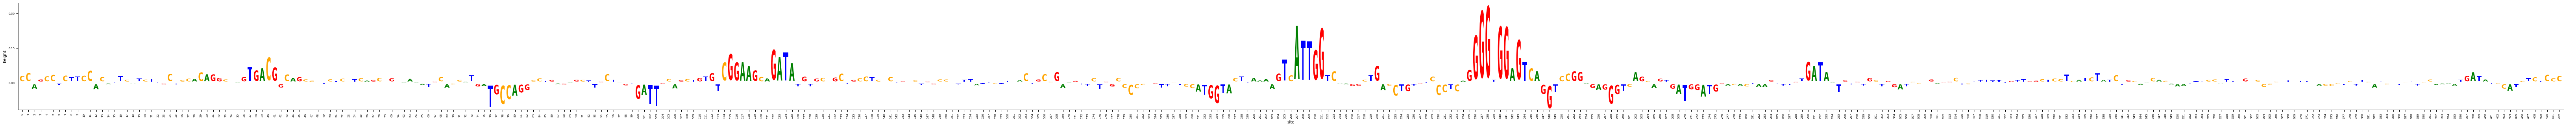

In [8]:
matrix = sequence_contributions.view(4,-1).detach()
y_max = matrix.max()
fig, ax = matrix_to_dms(matrix, y_max=y_max, fontaspect=.65, widthscale=0.8,
                  axisfontscale=0.6, heightscale=2)
plt.show()

### Test an individual sequence

In [9]:
batch_seq_idx = 300

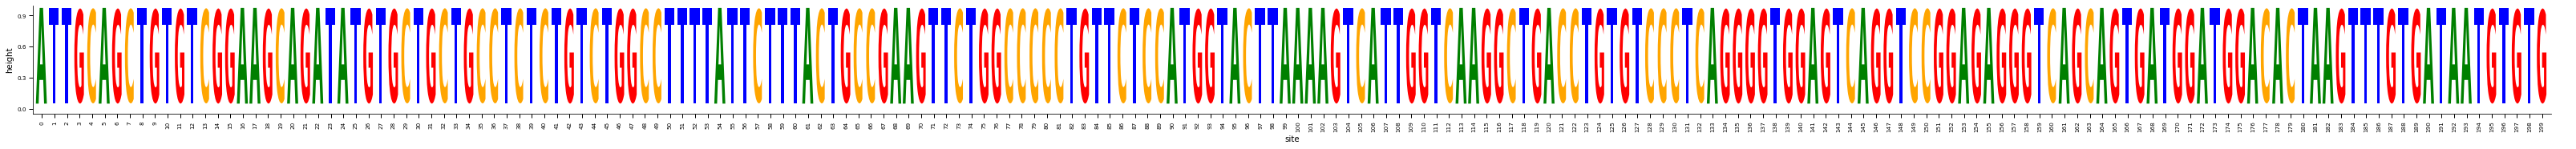

In [10]:
matrix = batch_tensor[batch_seq_idx,...].view(4,-1).detach().cpu()
y_max = matrix.max()
fig, ax = matrix_to_dms(matrix, y_max=y_max, fontaspect=.65, widthscale=0.8,
                  axisfontscale=0.6, heightscale=1)
plt.show()

In [11]:
# matrix = salient_maps[batch_seq_idx,...].view(4,-1).detach().cpu()
# y_max = matrix.max()
# fig, ax = matrix_to_dms(matrix, y_max=y_max, fontaspect=.65, widthscale=0.8,
#                   axisfontscale=0.6, heightscale=2)
# plt.show()

In [12]:
# matrix = extended_contributions[batch_seq_idx,...].view(4,-1).detach().cpu()
# y_max = matrix.max() + 0.2
# fig, ax = matrix_to_dms(matrix, y_max=y_max, fontaspect=.65, widthscale=0.8,
#                   axisfontscale=0.6, heightscale=2)
# plt.show()

In [13]:
%%time
eval_batch_size = 1040

test_sequence = ''.join(sequence_str.split('\n'))[batch_seq_idx:batch_seq_idx+200]
#print(test_sequence)

#saturated mutagenesis
sequence_as_string = test_sequence

combinations = []
for idx in range(len(sequence_as_string)):
    four_combinations = torch.stack([utils.dna2tensor(sequence_as_string[:idx] + base + sequence_as_string[idx+1:]) for base in constants.STANDARD_NT])
    combinations.append(four_combinations)
combinations = torch.stack(combinations).flatten(0,1)

salient_maps, extended_contributions = isg_contributions(combinations, k562_predictor, eval_batch_size=eval_batch_size)

saturated_contributions = salient_maps.unflatten(0, (200, 4))

  0%|          | 0/16 [00:00<?, ?it/s]

CPU times: user 1min 20s, sys: 171 ms, total: 1min 20s
Wall time: 1min 20s


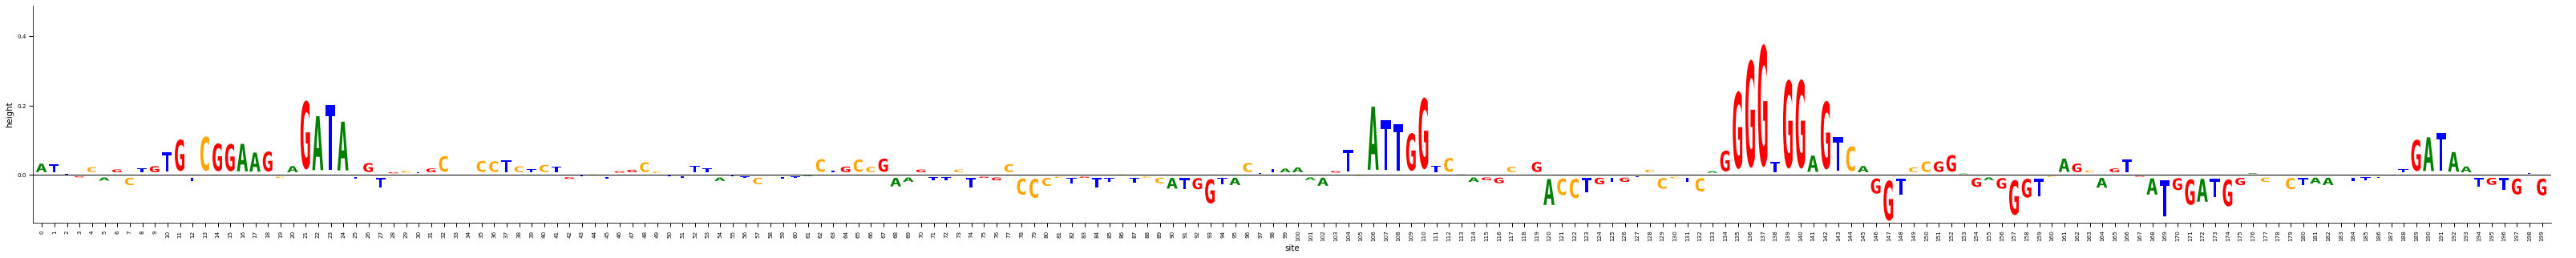

In [14]:
matrix = saturated_contributions[122,1,...].view(4,-1).detach().cpu()
y_max = matrix.max()
fig, ax = matrix_to_dms(matrix, y_max=y_max, fontaspect=.65, widthscale=0.8,
                  axisfontscale=0.6, heightscale=2)
plt.show()

In [15]:
saturated_predictions = k562_predictor(combinations.cuda())

In [16]:
base_prediction = k562_predictor(utils.dna2tensor(test_sequence).view(1,4,-1).cuda())
print(base_prediction)

tensor([1.1633], device='cuda:0', grad_fn=<SelectBackward>)


In [17]:
saturated_mutagenesis = saturated_predictions.unflatten(0, (200, 4)).T - base_prediction

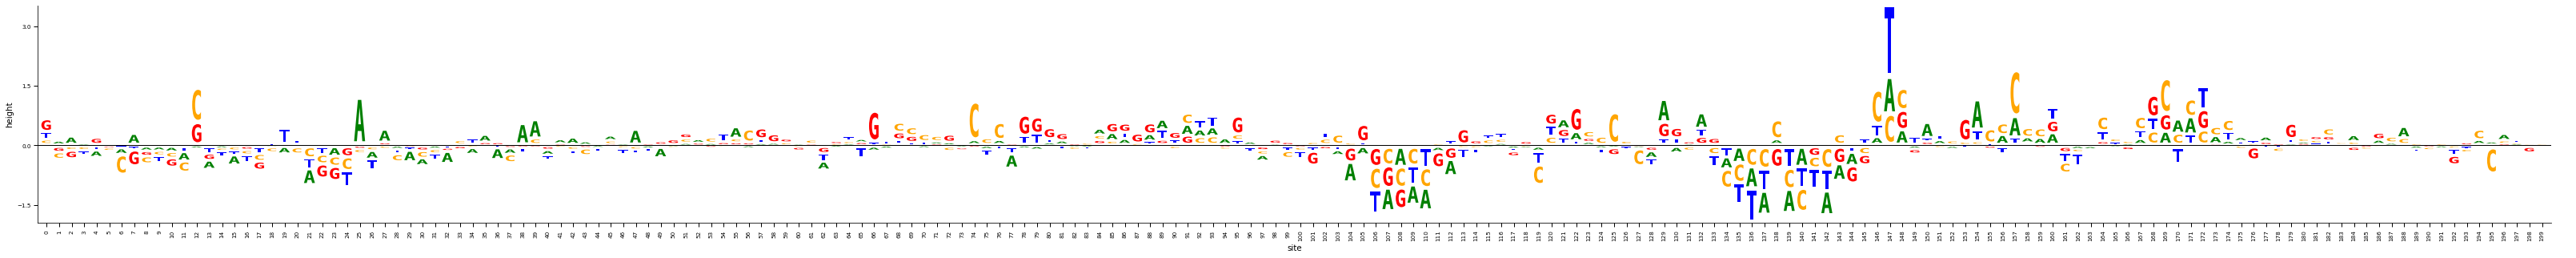

In [18]:
matrix = saturated_mutagenesis.view(4,-1).detach().cpu()
y_max = float(matrix.sum(dim=0).max())
fig, ax = matrix_to_dms(matrix, y_max=y_max, fontaspect=.65, widthscale=0.8,
                  axisfontscale=0.6, heightscale=2)
plt.show()

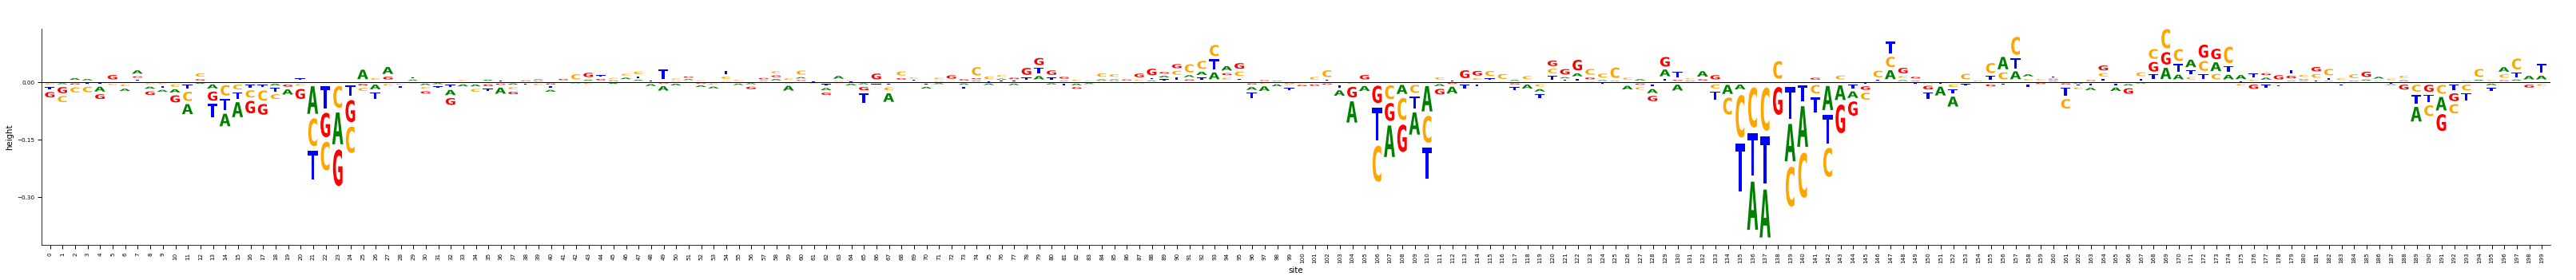

In [25]:
ref_tensor = utils.dna2tensor(test_sequence)
(torch.ones_like(ref_tensor) - ref_tensor) * extended_contributions[batch_seq_idx,...].view(4,-1).cpu()
matrix = (torch.ones_like(ref_tensor) - ref_tensor) * extended_contributions[199,...].view(4,-1).cpu()
y_max = float(matrix.sum(dim=0).max()) #+ 0.2
fig, ax = matrix_to_dms(matrix, y_max=y_max, fontaspect=.65, widthscale=0.8,
                  axisfontscale=0.6, heightscale=2)
#plt.ylim(-0.5,y_max)
plt.show()

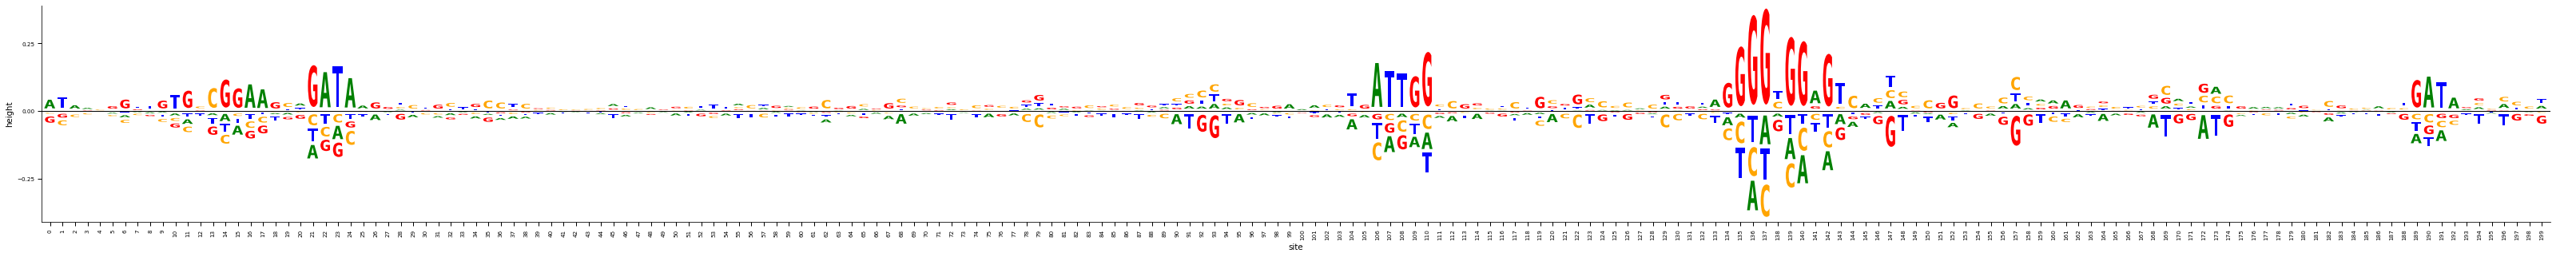

In [20]:
matrix = extended_contributions[batch_seq_idx,...].view(4,-1).detach().cpu()
y_max = matrix.max()
fig, ax = matrix_to_dms(matrix, y_max=y_max, fontaspect=.65, widthscale=0.8,
                  axisfontscale=0.6, heightscale=2)
plt.show()